In [6]:
# Import data from Google Drive
from google.colab import drive
drive.mount('/content/drive')

train_path = '/content/drive/MyDrive/dataset/train'
test_path =  '/content/drive/MyDrive/dataset/test'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [71]:
# Load libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Data Preparation

In [35]:
# Prepare the data
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=1,
    class_mode='sparse'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=1,
    class_mode='sparse'
)

Found 40 images belonging to 4 classes.
Found 25 images belonging to 4 classes.


# Model Building

In [77]:
# Load the pretrained Xception model
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base_model
base_model.trainable = False

# Add new classification layers
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(4, activation='softmax')
])

In [89]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 flatten_11 (Flatten)        (None, 100352)            0         
                                                                 
 dense_23 (Dense)            (None, 256)               25690368  
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_24 (Dense)            (None, 4)                 1028      
                                                                 
Total params: 46552876 (177.59 MB)
Trainable params: 25691396 (98.00 MB)
Non-trainable params: 20861480 (79.58 MB)
_________________________________________________________________


# Training

In [78]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
hist = model.fit(train_generator, epochs=7)

Epoch 1/7
40/40 [==============================] - 35s 776ms/step - loss: 15.2452 - accuracy: 0.6250
Epoch 2/7
40/40 [==============================] - 30s 730ms/step - loss: 1.7616 - accuracy: 0.9750
Epoch 3/7
40/40 [==============================] - 31s 777ms/step - loss: 0.1771 - accuracy: 0.9750
Epoch 4/7
40/40 [==============================] - 31s 767ms/step - loss: 2.3689 - accuracy: 0.9250
Epoch 5/7
40/40 [==============================] - 34s 846ms/step - loss: 0.5366 - accuracy: 0.9500
Epoch 6/7
40/40 [==============================] - 34s 854ms/step - loss: 0.1999 - accuracy: 0.9750
Epoch 7/7
40/40 [==============================] - 30s 758ms/step - loss: 0.0000e+00 - accuracy: 1.0000


# Testing

In [79]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Loss: {loss}, Accuracy: {accuracy}')

25/25 [==============================] - 7s 235ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Loss: 0.0, Accuracy: 1.0


# Save the model

In [80]:
# Save the model
model.save('Product_Classifier_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Inference

1/1 [==============================] - 0s 411ms/step


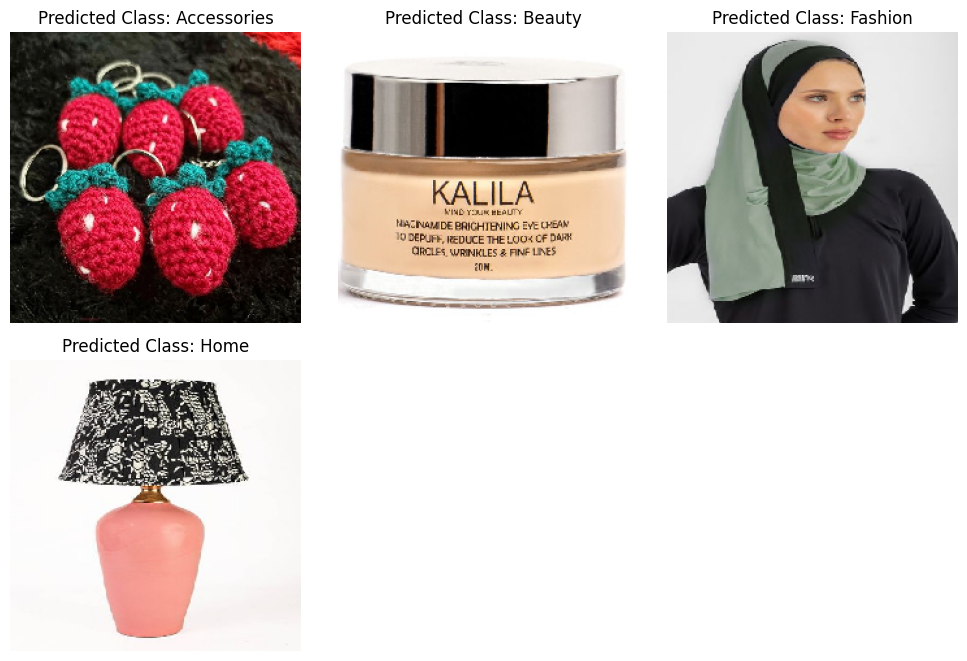

In [87]:
# Load your trained model for inference
model = load_model('Product_Classifier_model.h5')

# Path to the directory containing the images
images_dir = '/content/Inference/'

# List to store the images and predictions
images = []
class_labels = []

# Assume We have only four categories
class_labels_dict = {0: 'Fashion', 1: 'Accessories', 2:'Beauty', 3:'Home'}

# Loop through all the images in the directory
for img_file in os.listdir(images_dir):
    img_path = os.path.join(images_dir, img_file)
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0  # Normalize pixel values
    images.append(img)
    pred = model.predict(x)
    predicted_class = np.argmax(pred)
    class_labels.append(class_labels_dict[predicted_class])

# Plot the images with their predicted class labels
plt.figure(figsize=(10, 10))
for i in range(len(images)):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    plt.axis('off')
    plt.title(f'Predicted Class: {class_labels[i]}')

plt.tight_layout()
plt.savefig('predictions_plot.png')
plt.show()

# Deployment

In [51]:
import getpass
from pyngrok import ngrok, conf

In [54]:
conf.get_default().auth_token = getpass.getpass()

··········


In [88]:
%%writefile app.py
import streamlit as st
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model


model = load_model('Product_Classifier_model.h5')

class_labels_dict = {0: 'Fashion', 1: 'Accessories', 2:'Beauty', 3:'Home'}

st.title('Product Image Classifier')
st.text('Upload Image')

uploaded_img = st.file_uploader("Choose an image...", type='jpg')
if uploaded_img is not None:
  img = image.load_img(uploaded_img)
  st.image(img)

  if st.button('Predict'):
    x = image.smart_resize(img, (224, 224))
    x = image.img_to_array(x)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0  # Normalize pixel values
    pred = model.predict(x)
    predicted_class = np.argmax(pred)
    predicted_label = class_labels_dict[predicted_class]
    st.write(f'This item belongs to {predicted_label} category.')


Overwriting app.py


In [62]:
!nohup streamlit run app.py &

url = ngrok.connect("8501")
url

nohup: appending output to 'nohup.out'


<NgrokTunnel: "https://edbb-34-73-212-149.ngrok-free.app" -> "http://localhost:8501">